In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sklm
import xgboost as xgb
import matplotlib

In [2]:
train = pd.read_csv('train.csv', parse_dates = ['date'])
test = pd.read_csv('test.csv', parse_dates = ['date'])
submissions = pd.read_csv('SampleSubmission.csv')
vd = pd.read_csv('VariableDefinitionsHotspot.csv')

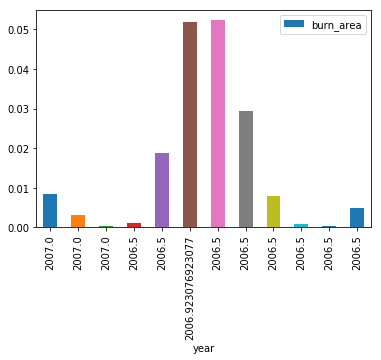

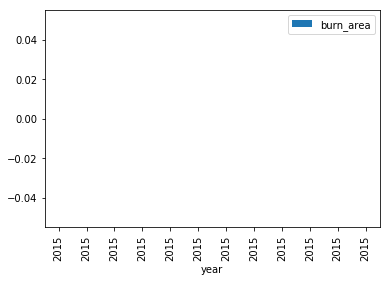

In [3]:
# Date variables
train['month'] = train.date.dt.month
train['year'] = train.date.dt.year

# Plotting mean burn_area for each month - very strong mid-year peak (dry season)
train.groupby('month').mean().reset_index().plot(y='burn_area', x='year', kind='bar')

# Date variables
test['month'] = test.date.dt.month
test['year'] = test.date.dt.year

# Plotting mean burn_area for each month - very strong mid-year peak (dry season)
test.groupby('month').mean().reset_index().plot(y='burn_area', x='year', kind='bar')

In [4]:
print(train.columns)

train = train.drop(['population_density', 'ID', 'date', 'climate_swe', 'landcover_0',
                    'landcover_1', 'landcover_2', 'landcover_3', 'landcover_5', 'landcover_6',
                    'landcover_7', 'landcover_8'], axis=1)
test = test.drop(['population_density', 'ID', 'burn_area', 'date', 'climate_swe', 'landcover_0','landcover_1', 
                  'landcover_2', 'landcover_3', 'landcover_5', 'landcover_6','landcover_7', 'landcover_8'], axis=1)

Index(['ID', 'area', 'date', 'lat', 'lon', 'burn_area', 'climate_aet',
       'climate_def', 'climate_pdsi', 'climate_pet', 'climate_pr',
       'climate_ro', 'climate_soil', 'climate_srad', 'climate_swe',
       'climate_tmmn', 'climate_tmmx', 'climate_vap', 'climate_vpd',
       'climate_vs', 'elevation', 'landcover_0', 'landcover_1', 'landcover_2',
       'landcover_3', 'landcover_4', 'landcover_5', 'landcover_6',
       'landcover_7', 'landcover_8', 'population_density', 'precipitation',
       'month', 'year'],
      dtype='object')


In [5]:
print(train.shape)
print(test.shape)

(626644, 22)
(137556, 21)


In [6]:
print(train.columns)
print(test.columns)

Index(['area', 'lat', 'lon', 'burn_area', 'climate_aet', 'climate_def',
       'climate_pdsi', 'climate_pet', 'climate_pr', 'climate_ro',
       'climate_soil', 'climate_srad', 'climate_tmmn', 'climate_tmmx',
       'climate_vap', 'climate_vpd', 'climate_vs', 'elevation', 'landcover_4',
       'precipitation', 'month', 'year'],
      dtype='object')
Index(['area', 'lat', 'lon', 'climate_aet', 'climate_def', 'climate_pdsi',
       'climate_pet', 'climate_pr', 'climate_ro', 'climate_soil',
       'climate_srad', 'climate_tmmn', 'climate_tmmx', 'climate_vap',
       'climate_vpd', 'climate_vs', 'elevation', 'landcover_4',
       'precipitation', 'month', 'year'],
      dtype='object')


In [7]:
Labels = np.array(train['burn_area'])
print(Labels)

[0.00368827 0.         0.         ... 0.         0.         0.        ]


In [8]:
train = train.drop('burn_area', axis=1)

In [9]:
Features = np.array(train)
test_enc = np.array(test)

In [10]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(Features[:, :])
Features[:, :] = scaler.transform(Features[:, :])
print(Features[:, :])

[[-1.73159757  0.43753111  1.85451289 ...  0.1322863  -0.75212307
  -1.68075649]
 [-1.73069097  0.49456614  1.85383075 ...  0.04842358 -0.75212307
  -1.68075649]
 [-1.72978438  0.43650345  1.80403446 ...  0.23004017 -0.75212307
  -1.68075649]
 ...
 [ 1.72978438  1.48445787 -2.34861303 ...  1.04469196  1.57520115
   1.60372824]
 [ 1.73069097  1.54174981 -2.34565709 ...  0.77124435  1.57520115
   1.60372824]
 [ 1.73159757  1.5450897  -2.39522601 ...  0.63133742  1.57520115
   1.60372824]]


In [11]:
scaler1 = preprocessing.StandardScaler().fit(test_enc[:, :])
test_enc[:, :] = scaler1.transform(test_enc[:, :])
#print(test_enc[:, :])

In [12]:
import numpy.random as nr
import sklearn.model_selection as ms
## Randomly sample cases to create independent training and test data
nr.seed(9988)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 0.2)
x_train = Features[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
x_test = Features[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

In [13]:
indx1 = range(x_train.shape[0])
indx1 = ms.train_test_split(indx1, test_size = 0.2)
x_train1 = x_train[indx1[0],:]
y_train1 = np.ravel(y_train[indx1[0]])
x_train_val = x_train[indx1[1],:]
y_train_val = np.ravel(y_train[indx1[1]])

In [14]:
xg_reg = xgb.XGBRegressor(objective = 'reg:logistic', n_estimators = 200, seed = 123, max_depth = 8,
                           learning_rate=0.01, booster = 'gbtree', base_score = 0.7, subsample = 0.8,
                           reg_lambda = 0.03)

eval_set = [(x_train1, y_train1), (x_test, y_test)]
xg_reg.fit(x_train1, y_train1, eval_metric="rmse", eval_set=eval_set, verbose=True, early_stopping_rounds = 10)

[0]	validation_0-rmse:0.68105	validation_1-rmse:0.68108
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.67386	validation_1-rmse:0.67425
[2]	validation_0-rmse:0.66721	validation_1-rmse:0.66737
[3]	validation_0-rmse:0.66070	validation_1-rmse:0.66084
[4]	validation_0-rmse:0.65397	validation_1-rmse:0.65424
[5]	validation_0-rmse:0.64728	validation_1-rmse:0.64753
[6]	validation_0-rmse:0.64118	validation_1-rmse:0.64118
[7]	validation_0-rmse:0.63456	validation_1-rmse:0.63475
[8]	validation_0-rmse:0.62829	validation_1-rmse:0.62831
[9]	validation_0-rmse:0.62186	validation_1-rmse:0.62206
[10]	validation_0-rmse:0.61569	validation_1-rmse:0.61591
[11]	validation_0-rmse:0.60956	validation_1-rmse:0.60976
[12]	validation_0-rmse:0.60344	validation_1-rmse:0.60363
[13]	validation_0-rmse:0.59745	validation_1-rmse:0.59750
[14]	validation_0-rmse:0.59140	validation_1-rmse:0.59

[141]	validation_0-rmse:0.16909	validation_1-rmse:0.16919
[142]	validation_0-rmse:0.16753	validation_1-rmse:0.16759
[143]	validation_0-rmse:0.16594	validation_1-rmse:0.16600
[144]	validation_0-rmse:0.16434	validation_1-rmse:0.16442
[145]	validation_0-rmse:0.16279	validation_1-rmse:0.16284
[146]	validation_0-rmse:0.16121	validation_1-rmse:0.16132
[147]	validation_0-rmse:0.15970	validation_1-rmse:0.15979
[148]	validation_0-rmse:0.15819	validation_1-rmse:0.15826
[149]	validation_0-rmse:0.15669	validation_1-rmse:0.15677
[150]	validation_0-rmse:0.15521	validation_1-rmse:0.15530
[151]	validation_0-rmse:0.15373	validation_1-rmse:0.15384
[152]	validation_0-rmse:0.15234	validation_1-rmse:0.15238
[153]	validation_0-rmse:0.15088	validation_1-rmse:0.15095
[154]	validation_0-rmse:0.14945	validation_1-rmse:0.14953
[155]	validation_0-rmse:0.14809	validation_1-rmse:0.14812
[156]	validation_0-rmse:0.14664	validation_1-rmse:0.14674
[157]	validation_0-rmse:0.14531	validation_1-rmse:0.14537
[158]	validati

XGBRegressor(base_score=0.7, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.01, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=200, n_jobs=0, num_parallel_tree=1,
       objective='reg:logistic', random_state=123, reg_alpha=0,
       reg_lambda=0.03, scale_pos_weight=1, seed=123, subsample=0.8,
       tree_method=None, validate_parameters=False, verbosity=None)

In [15]:
preds = xg_reg.predict(x_train_val)

In [16]:
preds

array([0.09439146, 0.09439146, 0.0943048 , ..., 0.0943048 , 0.09430378,
       0.0943048 ], dtype=float32)

In [17]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_train_val, preds)**0.5

0.0995809186435839

In [18]:
test_pred = xg_reg.predict(test_enc)

In [19]:
test.shape

(137556, 21)

In [20]:
submissions.Prediction = test_pred

In [21]:
submissions.head()

,ID,Prediction
0,0_2014-01-01,0.222586
1,1_2014-01-01,0.215696
2,2_2014-01-01,0.304010
3,3_2014-01-01,0.216214
4,4_2014-01-01,0.253072


In [22]:
submissions.to_csv('HotspotSubmission3.csv', index=False)

In [27]:
from sklearn.externals import joblib, load
joblib.dump(xg_reg, 'xgmodel.joblib')

ImportError: cannot import name 'load' from 'sklearn.externals' (C:\Users\hp\Anaconda3\lib\site-packages\sklearn\externals\__init__.py)

In [29]:
from joblib import load
model = load('xgmodel.joblib')

In [30]:
model

XGBRegressor(base_score=0.7, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.01, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=200, n_jobs=0, num_parallel_tree=1,
       objective='reg:logistic', random_state=123, reg_alpha=0,
       reg_lambda=0.03, scale_pos_weight=1, seed=123, subsample=0.8,
       tree_method=None, validate_parameters=False, verbosity=None)

In [31]:
model.predict(x_test)

array([0.09439146, 0.11986427, 0.09439146, ..., 0.0943048 , 0.09448704,
       0.09448765], dtype=float32)